In [ ]:
!pip install gpflow

     |████████████████████████████████| 271 kB 22.8 MB/s 


In [ ]:
import gpflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary, set_trainable
from gpflow.config import default_float

import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import gpflow
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable

%matplotlib inline
gpflow.config.set_default_float(np.float64)
f64 = gpflow.utilities.to_default_float

In [ ]:
def noisy_sin_function(x):
  """
  takes numpy array (x) as argument and computes sin of array.
  """
  # reproducibility: 
  # np.random.seed(1)
  return np.sin(x[:, 0]) * np.sin(x[:, 1]) + np.random.randn(x.shape[0]) * 0.01

def plot_function(input_xy):
  """
  Plots a sin function colormap for a 2d input with color representing value.
  """
  n = 100
  x = np.linspace(0, 4, n)
  y = np.linspace(0, 4, n)

  xx, yy = np.meshgrid(x, y)
  pts = np.vstack([xx.ravel(), yy.ravel()]).T

  # print(pts.shape)
  
  z = noisy_sin_function(pts)

  fig, ax = plt.subplots(figsize=(8,8))
  surf = ax.pcolor(xx, yy, z.reshape(n, n))
  plt.plot(input_xy[:,0], input_xy[:,1], 'o', color='k')
  plt.rc('font', size=16)  
  plt.xlabel("X1")
  plt.ylabel("X2")
  cbar = fig.colorbar(surf)
  cbar.set_label("f(x1 , x2)")
  plt.show()

def rect_points(start, end, n, ax):
  """

  returns an array of points in a rectangle.

  start = x axis where rectangle starts
  end = x axis where rectangle ends
  n = number of addition points
  ax = x axis where addition points are added
  """

  # holds points in square:
  points = []

  # base points to make square of 4 points:
  p1 = np.linspace(start,end, num=2)
  p2 = p1[::-1]
  points.append(p1)
  points.append(p2)
  points.append(np.array([start, start]))
  points.append(np.array([end, end]))

  # additional points:
  if ax==start or ax==end:
    n += 2
  p3 = np.linspace(start, end, num=n)

  points = np.array(points)

  for i in p3:
    l = np.array([ax, i])
    # print(l)
    # print((l == points).all(1).any())
    if not (l == points).all(1).any():
      points = np.append([l], points, axis=0)

  return points



# Input Space

(8, 2)
(8, 1)


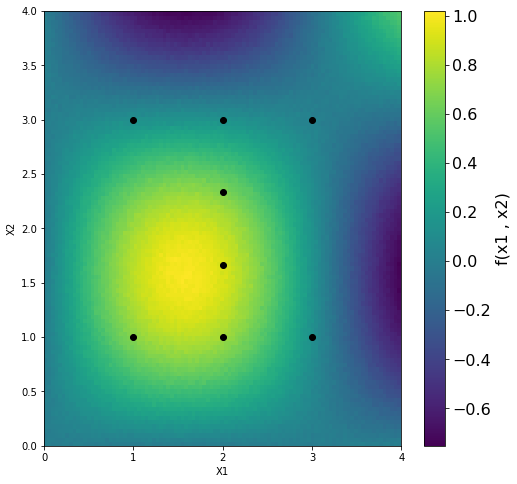

In [ ]:
num_data = 5
# input_xy = np.random.uniform(0,4,size=(num_data,2))
input_xy = rect_points(start=1,end=3,n=4, ax=2)
print(input_xy.shape)

z = noisy_sin_function(input_xy)
z = z.reshape(-1,1)

print(z.shape)

plot_function(input_xy)

# Algorithm Start
### obtain prior



In [ ]:
k = gpflow.kernels.SquaredExponential()
model = gpflow.models.GPR(data=(input_xy,z), kernel=k, mean_function=None)
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧════

In [ ]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, model.trainable_variables)

print(f"log posterior density at optimum: {model.log_posterior_density()}")
print_summary(model)

log posterior density at optimum: -0.013059087138540093
╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.211121    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 1.25082     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 1.00085e-06 │
╘═══════

In [ ]:
model.kernel.lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.likelihood.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
print_summary(model)

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 0.211121    │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 1.25082     │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │ Gamma   │ True        │ ()      │ float64 │ 1.00085e-06 │
╘═════════════════════════╧═══════════╧══════════════════╧══════

### MCMC Sampling

In [ ]:
num_burnin_steps = ci_niter(300)

num_hyper_samples = 500
num_samples = ci_niter(num_hyper_samples)

print(model.trainable_parameters)
# The SamplingHelper helps us convert our unconstrained values to constrained parameter ones
# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

# using HMC to sample from posterior:
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)

@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )

(<Parameter: dtype=float64, shape=[], fn="softplus", numpy=1.2508174336780415>, <Parameter: dtype=float64, shape=[], fn="softplus", numpy=0.2111212456436544>, <Parameter: dtype=float64, shape=[], fn="chain_of_shift_of_softplus", numpy=1.000852628090685e-06>)


### MCMC Samples

In [ ]:
samples, traces = run_chain_fn()
parameter_samples = hmc_helper.convert_to_constrained_values(samples)
print(type(parameter_samples[0]))
print(len(parameter_samples)) 
print(parameter_samples[0].shape) # samples from each hyperparam distribution? 0=kl, 1=kv, 2=nv
print(parameter_samples[0][0].numpy())
# print(parameter_samples[0])

param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}

<class 'tensorflow.python.framework.ops.EagerTensor'>
3
(500,)
2.1846438403714457


In [ ]:
print(parameter_samples[0].shape) # samples from each hyperparam distribution? 0=kl, 1=kv, 2=nv
print(parameter_samples[1][0].numpy())

(500,)
1.7714937772679915


In [ ]:
def get_mixture_stds(means, stds):
    """
    Return standard deviation of a k-component Gaussian mixture model, given an
    (k x n) array of k component means for n locations, and a (k x n) array of
    k component stds for n locations.
    """
    mixture_means = np.mean(means, axis=0)
    sums_squared_means_stds = means ** 2 + stds ** 2
    second_moments = np.mean(sums_squared_means_stds, axis=0)
    mixture_vars = second_moments - mixture_means ** 2
    mixture_stds = np.sqrt(mixture_vars)
    return mixture_stds

### Acquisition function loop to obtain equation term values

In [ ]:
NUM_POST_PRED = 20
sampled_hyper_indx = []

# np.random.seed(2) # ensures we are working with same indices  

# DIFFERENT TEST INDICES OF SAMPLED HYPERPARAMS OF SIZE NUM_POST_PRED:
for i in range(NUM_POST_PRED):
  sampled_hyper_indx.append(np.random.randint(0,num_hyper_samples))

# TESTING POINTS (INPUT):
n = 100
x = np.linspace(0, 4, n)
y = np.linspace(0, 4, n)

xx, yy = np.meshgrid(x, y)
test_points = np.vstack([xx.ravel(), yy.ravel()]).T
num_test = test_points.shape[0]

# test_points = np.linspace(0, 10, num=60).reshape(-1, 2) # shape (50, 2)
# test_points = np.random.uniform(0,4, size=(num_data,2))
# test_points = np.vstack((np.linspace(0,4,num_data).reshape(1,-1) for _ in [0,1])).T
print(test_points.shape)

# DIFFERENT TEST INDICES OF SAMPLED HYPERPARAMS:
print(f"sampled_hyper_indx: {sampled_hyper_indx}")

means = []
stds = []
entropies = []

for indx in sampled_hyper_indx:
  # CREATE GPR MODEL:
  k = gpflow.kernels.SquaredExponential()
  m = gpflow.models.GPR(data=(input_xy,z), kernel=k, mean_function=None) 

  # assign hyperparams from sampled hyperparam distributions:
  m.kernel.lengthscales.assign( parameter_samples[0][indx].numpy() )
  print(f"lengthscale: {parameter_samples[0][indx].numpy()}")

  m.kernel.variance.assign(parameter_samples[1][indx].numpy())
  print(f"kernel variance: {parameter_samples[1][indx].numpy()}")

  m.likelihood.variance.assign(parameter_samples[2][indx].numpy())
  print(f"noise variance: {parameter_samples[2][indx].numpy()}")

  # OBTAIN MEAN AND VARIANCE OF F AT A POINTS "test_points"
  mean, var = m.predict_f(test_points)
  print(mean.shape)
  print(var.shape)
  mean = np.squeeze(mean)
  std = np.sqrt( np.squeeze(var) )

  means += [mean]
  stds += [std]

  # CREATE GAUSSIAN DISTRIBUTIONS WITH MEAN AND VARIANCES AND FIND ENTROPY:
  e = [] # holds entropies for "num_test" distributions
  for i in range(num_test):
    distribution_2 = tfd.Normal( loc=mean[i], scale=var[i] )
    e.append(distribution_2.entropy().numpy())
    # print(f'mean {mean[i]}, var {var[i]}, entropy {distribution_2.entropy().numpy()}')

  entropies.append(e)

(10000, 2)
sampled_hyper_indx: [178, 70, 26, 340, 340, 405, 454, 165, 146, 134, 112, 354, 356, 175, 466, 378, 368, 32, 401, 345]
lengthscale: 2.012108054443413
kernel variance: 1.1076457987554602
noise variance: 0.02643373495758274
(10000, 1)
(10000, 1)
lengthscale: 1.3705202218976353
kernel variance: 1.9465800971907155
noise variance: 0.00021819256813726404
(10000, 1)
(10000, 1)
lengthscale: 1.8918271199665866
kernel variance: 1.3696933693200117
noise variance: 3.071628438359973e-05
(10000, 1)
(10000, 1)
lengthscale: 1.1903865631786967
kernel variance: 0.37937855220297484
noise variance: 0.32679730739474355
(10000, 1)
(10000, 1)
lengthscale: 1.1903865631786967
kernel variance: 0.37937855220297484
noise variance: 0.32679730739474355
(10000, 1)
(10000, 1)
lengthscale: 2.825044316932895
kernel variance: 0.3968448430357838
noise variance: 0.14985185688523514
(10000, 1)
(10000, 1)
lengthscale: 4.435855109183498
kernel variance: 1.5113991929010828
noise variance: 0.13131735231974626
(10000,

### Final Results

In [ ]:
means = np.array(means)
stds = np.array(stds)
entropies = np.array(entropies)

# COMPUTATIONS TO OBTAIN 1ST TERM IN EQUATION:
print(f"average mean: {np.mean(means, axis=0)}")
print(f"std deviation of means: {np.std(means, axis=0)}")
mixture_means = np.mean(means, axis=0)
mixture_stds = get_mixture_stds(means, stds)
distribution_1 = tfd.Normal(loc=mixture_means, scale=mixture_stds)

entropy_of_avg = distribution_1.entropy().numpy().reshape(-1,1)

# COMPUTATIONS TO OBTAIN 2ND TERM IN EQUATION:
avg_entropy = np.mean(entropies, axis=0)
print(avg_entropy.shape)

# stick in variable:
print(f"ENTROPY OF AVG (1st term): {entropy_of_avg}")
print(f"AVG OF ENTROPY (2nd term): {avg_entropy}")

acq_value = entropy_of_avg - avg_entropy
print(f"ACQUISITION FUNCTION VALUE: {acq_value}")
print()





average mean: [ 0.19479673  0.20174086  0.20875377 ... -0.10517404 -0.10341268
 -0.10167201]
std deviation of means: [0.29006601 0.28657379 0.28305584 ... 0.11756956 0.11581559 0.1142105 ]
(10000, 1)
ENTROPY OF AVG (1st term): [[0.85088415]
 [0.83896819]
 [0.82699843]
 ...
 [0.7049442 ]
 [0.71526837]
 [0.72573471]]
AVG OF ENTROPY (2nd term): [[-0.20141128]
 [-0.22129016]
 [-0.24126297]
 ...
 [-0.24126297]
 [-0.22129016]
 [-0.20141128]]
ACQUISITION FUNCTION VALUE: [[1.05229543]
 [1.06025835]
 [1.06826139]
 ...
 [0.94620717]
 [0.93655853]
 [0.927146  ]]



In [ ]:
acq_opt_idx = np.argmax(acq_value)
print(f'acq_opt_idx = {acq_opt_idx}')
mat_idx_1 = int(acq_opt_idx / 100)
mat_idx_2 = acq_opt_idx - (mat_idx_1 * 100)
print(mat_idx_1)
print(mat_idx_2)
print(xx[mat_idx_1, mat_idx_2])
print(yy[mat_idx_1, mat_idx_2])

acq_opt_idx = 4449
44
49
1.97979797979798
1.777777777777778


(8, 2)


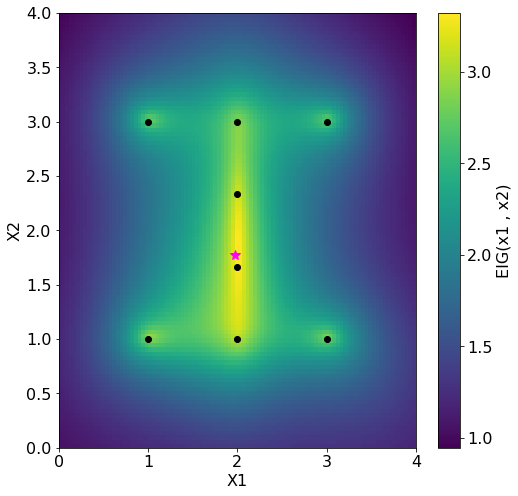

In [ ]:
print(input_xy.shape)
plt.figure(figsize=(8, 8))
plt.rc('font', size=16)  
plt.xlabel("X1")
plt.ylabel("X2")
plt.pcolor(xx,yy,acq_value.reshape(n,n))
plt.plot(input_xy[:,0], input_xy[:,1], 'o', color='k')
plt.plot(xx[mat_idx_1, mat_idx_2], yy[mat_idx_1, mat_idx_2], '*', c="magenta", markersize=10)
cbar = plt.colorbar()
cbar.set_label("EIG(x1 , x2)")

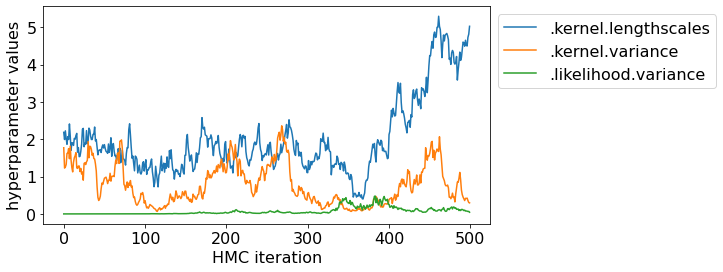

In [ ]:
def plot_samples(samples, parameters, y_axis_label):
    plt.figure(figsize=(8, 4))
    for val, param in zip(samples, parameters):
        plt.plot(tf.squeeze(val), label=param_to_name[param])
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.xlabel("HMC iteration")
    plt.ylabel(y_axis_label)


# plot_samples(samples, model.trainable_parameters, "unconstrained values")
plot_samples(parameter_samples, model.trainable_parameters, "hyperparameter values")

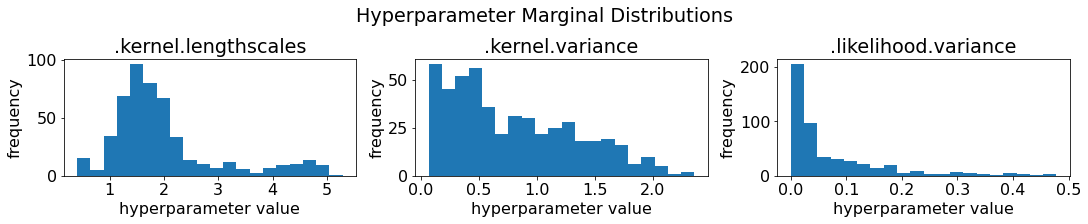

In [ ]:
def marginal_samples(samples, parameters, y_axis_label):
    fig, axes = plt.subplots(1, len(param_to_name), figsize=(15, 3), constrained_layout=True)
    for ax, val, param in zip(axes, samples, parameters):
        ax.hist(np.stack(val).flatten(), bins=20)
        ax.set_title(param_to_name[param])
        ax.set_ylabel('frequency')
        ax.set_xlabel('hyperparameter value')
    fig.suptitle(y_axis_label)
    plt.show()


# marginal_samples(samples, model.trainable_parameters, "unconstrained variable samples")
marginal_samples(parameter_samples, model.trainable_parameters, "Hyperparameter Marginal Distributions")